In [2]:
import cbpro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import arrow
from requests.auth import AuthBase
import plotly.graph_objs as go


pd.options.display.max_rows = 4000
pd.options.display.max_columns = 4000


In [3]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from plotly import tools
import plotly.figure_factory as ff

# Read CSV File

In [4]:
#new_df.to_csv('ETHUSD5M.csv',index=False)

In [178]:
test = pd.read_csv('BTCHourly.csv')

test.shape

(44425, 6)

In [179]:
test.head()

,Date,Low,High,Open,Close,Volume
0,2021-01-25 00:00,32210.17,32850.00,32293.18,32596.42,1272.428729
1,2021-01-24 23:00,32044.46,32394.02,32148.61,32288.56,592.495060
2,2021-01-24 22:00,31687.39,32366.50,31934.22,32152.93,809.949737
3,2021-01-24 21:00,31605.31,31999.87,31700.14,31936.65,493.539396
4,2021-01-24 20:00,31279.33,31775.65,31340.15,31697.78,767.555321


In [180]:
#test.drop('Unnamed: 0',axis=1,inplace=True)
test = test.sort_values('Date')

In [181]:
test['avg'] = (test[['Low','High','Close']].sum(axis=1))/3

In [182]:
#test = test.set_index('Date')
test = test[['Date','Open','High','Low','Close','Volume','avg']].copy()
test.columns = ['Date','Open','High','Low','Close','Volume','avg']

In [183]:
test.head()

,Date,Open,High,Low,Close,Volume,avg
44424,2016-01-01 00:00,430.35,431.82,430.35,430.61,160.179593,430.926667
44423,2016-01-01 01:00,430.59,430.98,430.00,430.78,92.132315,430.586667
44422,2016-01-01 02:00,430.80,430.89,430.50,430.62,93.024327,430.670000
44421,2016-01-01 03:00,430.62,432.84,430.31,432.84,103.811532,431.996667
44420,2016-01-01 04:00,432.74,437.15,432.72,436.12,363.875951,435.330000


In [184]:
test['Date'] = pd.to_datetime(test['Date'])

In [185]:
test = test.set_index('Date',drop=True)
test.head(5)

,Open,High,Low,Close,Volume,avg
Date,,,,,,
2016-01-01 00:00:00,430.35,431.82,430.35,430.61,160.179593,430.926667
2016-01-01 01:00:00,430.59,430.98,430.00,430.78,92.132315,430.586667
2016-01-01 02:00:00,430.80,430.89,430.50,430.62,93.024327,430.670000
2016-01-01 03:00:00,430.62,432.84,430.31,432.84,103.811532,431.996667
2016-01-01 04:00:00,432.74,437.15,432.72,436.12,363.875951,435.330000


In [186]:
#Create my technical analysis indicators which are going to be my features

x = ['Close','Volume','avg']
t1 = 8
t2 = 16
for i in test[x]:

    c1 = 'rtn_' + i
    c2 = 'abs_rtn_' + i
    test[c1] = np.log(test[i]/test[i].shift(1))
    test[c2] = abs(np.log(test[i]/test[i].shift(1)))
    c3 = i + '_std' + str(t1)
    c4 = i + '_std' + str(t2) 
    test[c3] = test[i].rolling(window=t1).std()
    test[c4] = test[i].rolling(window=t2).std()
    
    c5 = c2 + '_' + str(t1) + 'MA'
    c6 = c2 + '_' + str(t2) + 'MA'
    test[c5] = test[c2].rolling(window=t1).mean()
    test[c6] = test[c2].rolling(window=t2).mean()
    c7 = i + '_' + str(t1) + 'EMA'
    c8 = i + '_' + str(t2) + 'EMA'
    test[c7] = test[i].ewm(span=t1,adjust=True).mean()
    test[c8] = test[i].ewm(span=t2,adjust=True).mean()
    c9 = i + '_' + str(t1) + 'MA'
    c10 = i + '_' + str(t2) + 'MA'
    test[c9] = test[i].rolling(window=t1).mean()
    test[c10] = test[i].rolling(window=t2).mean()
    
   
    c11 = 'Diff_' + c8 + c7
    test[c11] = test[c8] - test[c7]
        #Bollinger on Close price
    if i == 'Close' or 'avg':
        
        bol1 = ['BolUp'+c9,'BolDn'+c9]
        bol2 = ['BolUp'+c10,'BolDn'+c10]

        test[bol1[0]] = test[i].rolling(window=t1).mean() + (test[c2]*2.5) 
        test[bol1[1]] = test[i].rolling(window=t1).mean() - (test[c2]*2.5)
        test[bol2[0]] = test[i].rolling(window=t2).mean() + (test[c3]*2.5)
        test[bol2[1]] = test[i].rolling(window=t2).mean() - (test[c3]*2.5) 


In [187]:
#Create the RSI, Relative Strength Indicator 

rsi_period = 14
rsi = pd.DataFrame(test['Close'],index=test.index)
rsi['rtn'] = rsi['Close'].diff(periods=1)
rsi['po_rtn'] = [x if x > 0 else 0 for x in rsi['rtn']]
rsi['neg_rtn'] = [x if x < 0 else 0 for x in rsi['rtn']]
#rsi = rsi.iloc[1:,:]
rsi['RS'] = rsi['po_rtn'].ewm(span=rsi_period).mean()/rsi['neg_rtn'].abs().ewm(span=rsi_period).mean()
rsi['rsi'] = 100-(100/(1+rsi['RS']))

In [188]:
test['RSI_Close'] = rsi['rsi']

In [189]:
test.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'avg', 'rtn_Close',
       'abs_rtn_Close', 'Close_std8', 'Close_std16', 'abs_rtn_Close_8MA',
       'abs_rtn_Close_16MA', 'Close_8EMA', 'Close_16EMA', 'Close_8MA',
       'Close_16MA', 'Diff_Close_16EMAClose_8EMA', 'BolUpClose_8MA',
       'BolDnClose_8MA', 'BolUpClose_16MA', 'BolDnClose_16MA', 'rtn_Volume',
       'abs_rtn_Volume', 'Volume_std8', 'Volume_std16', 'abs_rtn_Volume_8MA',
       'abs_rtn_Volume_16MA', 'Volume_8EMA', 'Volume_16EMA', 'Volume_8MA',
       'Volume_16MA', 'Diff_Volume_16EMAVolume_8EMA', 'BolUpVolume_8MA',
       'BolDnVolume_8MA', 'BolUpVolume_16MA', 'BolDnVolume_16MA', 'rtn_avg',
       'abs_rtn_avg', 'avg_std8', 'avg_std16', 'abs_rtn_avg_8MA',
       'abs_rtn_avg_16MA', 'avg_8EMA', 'avg_16EMA', 'avg_8MA', 'avg_16MA',
       'Diff_avg_16EMAavg_8EMA', 'BolUpavg_8MA', 'BolDnavg_8MA',
       'BolUpavg_16MA', 'BolDnavg_16MA', 'RSI_Close'],
      dtype='object')

In [190]:
#Volume indicator
test['Volume_ratio'] = test['Volume'] / test['Volume_8MA']

#Features to locate the price divergence from the bollinger bands
test['Close_MAs_ratio'] = test['Close_16MA'] / test['Close_8MA']
test['DnBol_Dist_16'] = test['Close'] - test['BolDnClose_16MA']
test['UpBol_Dist_16'] = test['Close'] - test['BolUpClose_16MA']
test['Dist_BolDn_BolUp'] = test['BolUpClose_16MA'] - test['BolDnClose_16MA']

In [191]:
#Average true range calculation, volatility indicator

t3 = 14  #the standard period for daily chart
ATR = pd.DataFrame()
ATR['HighLow'] = test['High'] - test['Low']
ATR['High_Close-1'] = abs(test['High'] - test['Close'].shift(-1))
ATR['Low_Close-1'] = abs(test['Low'] - test['Close'].shift(-1))
ATR['True_Range'] = ATR.max(axis=1)
ATR['ATR'] = ATR['True_Range'].rolling(window=t3).mean()

In [192]:
test['ATR'] = ATR['ATR']

In [193]:
#test = pd.read_csv('data-eth-15min.csv')
#test = test.set_index(pd.to_datetime(test['Date']))

In [194]:
support = pd.DataFrame(test['Close'])
support.head()

,Close
Date,
2016-01-01 00:00:00,430.61
2016-01-01 01:00:00,430.78
2016-01-01 02:00:00,430.62
2016-01-01 03:00:00,432.84
2016-01-01 04:00:00,436.12


In [195]:
#trying to find support support and resistance via the differentiation. We know that a derivative is equal to 0 for 
# minima and maxima. Although it doesnt really work here as price is a random walk
supports = pd.DataFrame()
supports['diff'] = test['Close_8EMA'].diff(3)
supports['lagged_diff'] = supports['diff'].shift(-1)
supports['forward_diff'] = supports['diff'].shift(1)
supports.fillna(0,inplace=True)
supports.head()

,diff,lagged_diff,forward_diff
Date,,,
2016-01-01 00:00:00,0.000000,0.000000,0.000000
2016-01-01 01:00:00,0.000000,0.000000,0.000000
2016-01-01 02:00:00,0.000000,0.820341,0.000000
2016-01-01 03:00:00,0.820341,2.181506,0.000000
2016-01-01 04:00:00,2.181506,3.103014,0.820341


In [196]:
supports.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44425 entries, 2016-01-01 00:00:00 to 2021-01-25 00:00:00
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diff          44425 non-null  float64
 1   lagged_diff   44425 non-null  float64
 2   forward_diff  44425 non-null  float64
dtypes: float64(3)
memory usage: 1.4 MB


In [197]:
supports['pivot'] = np.where(((supports['lagged_diff'] < 0) & (supports['forward_diff'] > 0)), 1,
                                np.where(((supports['lagged_diff'] > 0) & (supports['forward_diff'] < 0)), 2, 0))

In [198]:
supports.head()

,diff,lagged_diff,forward_diff,pivot
Date,,,,
2016-01-01 00:00:00,0.000000,0.000000,0.000000,0
2016-01-01 01:00:00,0.000000,0.000000,0.000000,0
2016-01-01 02:00:00,0.000000,0.820341,0.000000,0
2016-01-01 03:00:00,0.820341,2.181506,0.000000,0
2016-01-01 04:00:00,2.181506,3.103014,0.820341,0


In [199]:
test['pivot'] = supports['pivot']

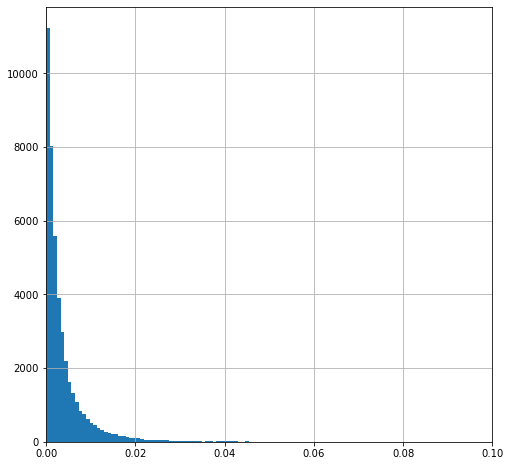

In [200]:
fig, ax = plt.subplots(figsize=(8,8))
test['abs_rtn_avg'].hist(bins=500)
plt.xlim(0,0.1)
plt.show()

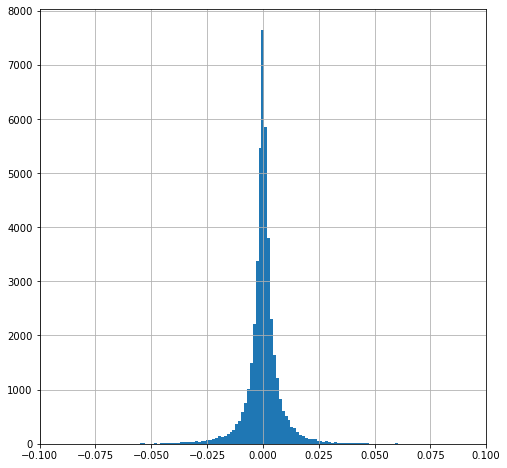

In [201]:
fig, ax = plt.subplots(figsize=(8,8))
test['Close'].pct_change(periods=1).hist(bins=300)
plt.xlim(-0.10,0.10)
plt.show()

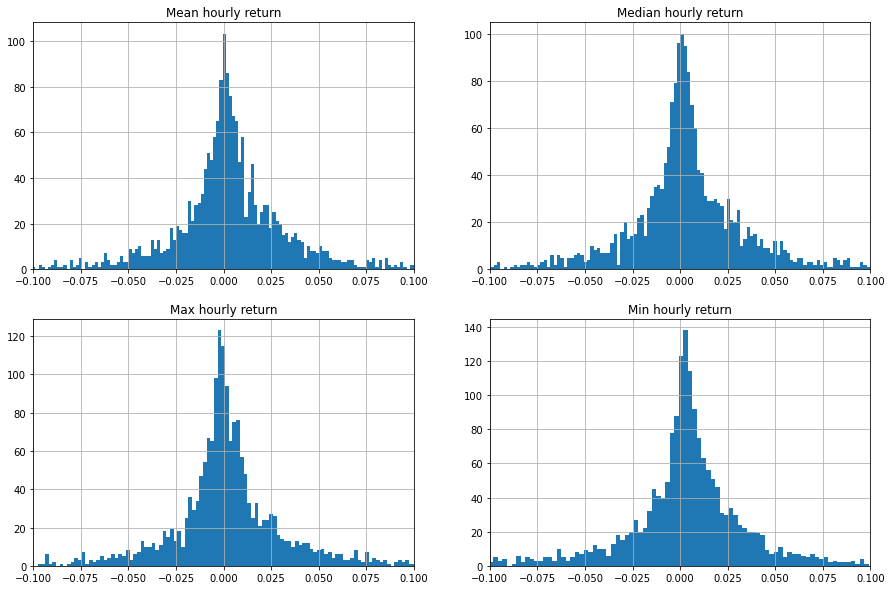

In [202]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
test.resample('D').mean()['Close'].pct_change(periods=1).hist(bins=250,ax=ax[0,0])
test.resample('D').median()['Close'].pct_change(periods=1).hist(bins=250,ax=ax[0,1])
test.resample('D').max()['Close'].pct_change(periods=1).hist(bins=250,ax=ax[1,0])
test.resample('D').min()['Close'].pct_change(periods=1).hist(bins=250,ax=ax[1,1])
ax[0,0].set_title('Mean hourly return')
ax[0,1].set_title('Median hourly return')
ax[1,0].set_title('Max hourly return')
ax[1,1].set_title('Min hourly return')
ax[0,0].set_xlim(-0.10,0.10)
ax[0,1].set_xlim(-0.10,0.10)
ax[1,0].set_xlim(-0.10,0.10)
ax[1,1].set_xlim(-0.10,0.10)
plt.show()

In [203]:
trace0 = go.Scatter(x=test.index, y=test['avg'], name='avg', line=dict(color='lime'))
trace1 = go.Scatter(x=test.index, y=test['avg_7MA'], name='60MA', line=dict(color='grey'))
#trace2 = go.Scatter(x=test.index, y=test['avg'].rolling(window=96).mean(), name='96MA', line=dict(color='red'))
#trace3 = go.Scatter(x=test.index, y=test['BolUpavg_96MA'], 
#                    name='Bup', line=dict(color='blue'),marker=dict(size = 15, color = 'blue', symbol = 'cross'))
#trace4 = go.Scatter(x=test.index, y=test['BolDnavg_96MA'], 
#                    name='Bdn', line=dict(color='blue'),marker=dict(size = 15, color = 'blue', symbol = 'cross'))

#trace4 = go.Scatter(x=test.index, y=test['pivot'], 
#                    name='Bdn', line=dict(color='blue'),marker=dict(size = 15, color = 'blue', symbol = 'cross'))

#data = [trace0, trace1, trace2,trace3, trace4]
data = [trace0, trace1]
layout = dict(
            title='ETH',
              xaxis = dict(
        range = [min(test.index),max(test.index)]
              )
             )

fig = dict(data=data, layout=layout)
py.iplot(fig)

KeyError: 'avg_7MA'

In [206]:
#Create my target variable: 
# return for the next 30min (15min data),
# return for the next 4h (hourly data), 
# return the next 2d (daily data),
# Then make a column that says if the return is positive or negative (flat return included) .
test['Return_4h'] = test['Close'].ewm(span=1).mean().pct_change(4).shift(-5)

In [207]:
test[['Close','Return_4h']].head()

,Close,Return_4h
Date,,
2016-01-01 00:00:00,430.61,0.012094
2016-01-01 01:00:00,430.78,0.008453
2016-01-01 02:00:00,430.62,0.003881
2016-01-01 03:00:00,432.84,-0.005870
2016-01-01 04:00:00,436.12,-0.006835


In [208]:
test['Return_4h'].describe()

count    44420.000000
mean         0.000523
std          0.016383
min         -0.274947
25%         -0.004416
50%          0.000421
75%          0.005630
max          0.271890
Name: Return_4h, dtype: float64

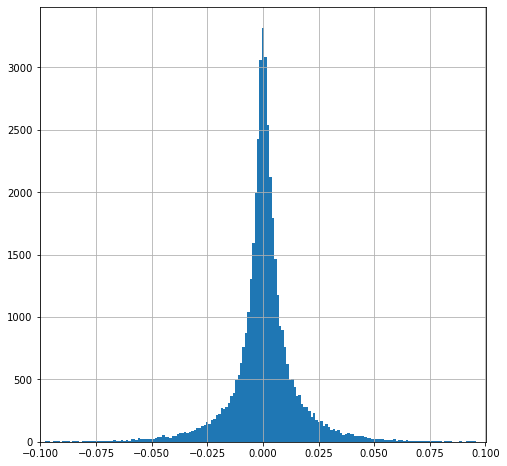

In [209]:
fig, ax = plt.subplots(figsize=(8,8))
test['Return_4h'].hist(bins=500)
plt.xlim(-0.1003,0.1003)
plt.show()

In [210]:
test[test['Return_4h'] == 0.000000].loc[:,'Return_4h']

Date
2016-01-06 16:00:00    0.0
2016-01-07 17:00:00    0.0
2016-01-30 09:00:00    0.0
2016-02-28 15:00:00    0.0
2016-03-11 08:00:00    0.0
2016-03-14 06:00:00    0.0
2016-03-16 09:00:00    0.0
2016-04-01 06:00:00    0.0
2016-04-26 00:00:00    0.0
2016-05-23 02:00:00    0.0
2016-07-16 18:00:00    0.0
2016-07-24 04:00:00    0.0
2016-08-13 08:00:00    0.0
2016-08-21 20:00:00    0.0
2016-09-06 20:00:00    0.0
2016-09-09 11:00:00    0.0
2016-09-12 03:00:00    0.0
2016-09-22 06:00:00    0.0
2016-09-28 10:00:00    0.0
2016-09-29 05:00:00    0.0
2016-10-09 05:00:00    0.0
2016-11-12 16:00:00    0.0
2016-11-28 11:00:00    0.0
2016-12-02 11:00:00    0.0
2017-01-28 07:00:00    0.0
2017-01-30 09:00:00    0.0
2017-02-11 11:00:00    0.0
2017-02-19 19:00:00    0.0
2017-02-28 18:00:00    0.0
2017-02-28 19:00:00    0.0
2017-04-16 17:00:00    0.0
2017-04-20 10:00:00    0.0
2017-07-24 16:00:00    0.0
2017-08-13 13:00:00    0.0
2018-05-02 07:00:00    0.0
2018-07-31 13:00:00    0.0
2018-08-10 00:00:00    

In [211]:
test['BuyorSell'] = [-1 if x <= 0 else 1 for x in test['Return_4h']]

In [212]:
# I am including the flat return to the positive return target variable in the model notebook.
test['BuyorSell'].value_counts(normalize=True)

 1    0.529229
-1    0.470771
Name: BuyorSell, dtype: float64

In [213]:
#Saving the finale data
test.to_csv('data-btc-hourly.csv')